In [1]:
# =========================================================
# 1. Data Preparation
# =========================================================
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from imshow import imshow
from ImageClassifier import ImageClassifier
from MetricsCallback import MetricsCallback
from visualizations import generate_visualizations
from torch import nn

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Fix random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Transformations
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Dataset
root_dir = "data"
dataset = ImageFolder(root=root_dir, transform=transform)
class_names = dataset.classes
print(class_names)

# Train/validation split
train_size = int(0.8*len(dataset))
val_size = len(dataset)-train_size
train_dataset, val_dataset = random_split(dataset,[train_size,val_size], generator=torch.Generator().manual_seed(SEED))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Create reports folder
os.makedirs("reports/figures", exist_ok=True)

# Class distribution
counts = pd.Series([dataset.targets.count(i) for i in range(len(class_names))], index=class_names)
class_dist = pd.DataFrame({"Class":class_names, "Count":counts.values})
class_dist.to_csv("reports/class_distribution.csv", index=False)

# Image dimension summary
sizes = [Image.open(dataset.samples[i][0]).size for i in range(len(dataset))]
widths, heights = zip(*sizes)
dim_df = pd.DataFrame({"Width":widths, "Height":heights})
dim_summary = dim_df.describe().round(2)
dim_summary.to_csv("reports/image_dimensions_summary.csv")

# Train/val split summary
split_df = pd.DataFrame({"Set":["Train","Validation"], "Samples":[len(train_dataset),len(val_dataset)]})
split_df.to_csv("reports/train_validation_distribution.csv", index=False)


# =========================================================
# 2. Model Definition & Training
# =========================================================
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve



# =========================================================
# 3. Metrics Callback
# =========================================================
from pytorch_lightning.callbacks import Callback



metrics_cb = MetricsCallback()


# =========================================================
# 4. Train Model
# =========================================================
model = ImageClassifier(num_classes=len(class_names))
trainer = Trainer(max_epochs=3, accelerator="auto", deterministic=True, callbacks=[metrics_cb], num_sanity_val_steps=0)
trainer.fit(model, train_loader, val_loader)


# =========================================================
# 5. Model Evaluation
# =========================================================
all_preds, all_labels, all_probs = [],[],[]
model.eval()
with torch.no_grad():
    for x,y in val_loader:
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:,1]
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())
        all_probs.extend(probs.numpy())

cm = confusion_matrix(all_labels, all_preds)
frac_pos, mean_pred = calibration_curve(all_labels, all_probs, n_bins=8)
print()
calib_error = np.abs(frac_pos-mean_pred).mean()

# Compute per-sample loss for misclassified examples
losses, samples, labels_np, pred_probs = [], [], [], []
with torch.no_grad():
    for x,y in val_loader:
        print("New batch")
        logits = model(x)
        print("Logits: ",  logits)
        probs = torch.softmax(logits, dim=1)[:, 1]
        print("probs: ", probs)
        loss_batch = nn.CrossEntropyLoss(reduction="none")(logits,y)
        preds_batch = torch.argmax(logits, dim=1)
        mask = preds_batch != y
        print(sum(mask))
        if mask.any():
            losses.extend(loss_batch[mask].numpy())
            samples.extend(x[mask].numpy())
            labels_np.extend(y[mask].numpy())
            pred_probs.extend(probs[mask].numpy())
losses = np.array(losses)
samples = np.array(samples)
labels_np = np.array(labels_np)
pred_probs = np.array(pred_probs)

# Select top-k misclassified per class
k = 6
top_samples=[]
for c in range(len(class_names)):
    idx_class = np.where(labels_np==c)[0]
    idx_top = idx_class[np.argsort(losses[idx_class])[-(k//2):]]
    top_samples.extend(idx_top)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


['pain_au_chocolat', 'sloths']


You are using a CUDA device ('NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-10-20 11:24:06.696367: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 11:24:06.766095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the approp

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.



New batch
Logits:  tensor([[ 1.3798, -2.6829],
        [-2.2389,  3.3911],
        [-0.6808,  0.7405],
        [-1.5691,  2.2938]])
probs:  tensor([0.0169, 0.9964, 0.8055, 0.9794])
tensor(0)
New batch
Logits:  tensor([[-1.4306,  2.1261],
        [ 1.2023, -2.3147],
        [ 1.3084, -2.6278],
        [-2.3800,  3.5263]])
probs:  tensor([0.9723, 0.0288, 0.0191, 0.9973])
tensor(0)
New batch
Logits:  tensor([[-1.3149,  2.0637],
        [-1.3716,  2.1415],
        [ 1.3943, -2.6118],
        [ 0.3957, -0.8350]])
probs:  tensor([0.9670, 0.9711, 0.0179, 0.2261])
tensor(0)
New batch
Logits:  tensor([[-1.4504,  2.2281],
        [-1.9624,  3.0207],
        [ 1.6672, -3.5779],
        [ 0.8845, -1.6872]])
probs:  tensor([0.9754, 0.9932, 0.0052, 0.0710])
tensor(0)
New batch
Logits:  tensor([[-1.9804,  2.9227],
        [ 0.5068, -1.1916],
        [-0.6929,  0.8408],
        [-0.9324,  1.4970]])
probs:  tensor([0.9926, 0.1547, 0.8225, 0.9190])
tensor(1)
New batch
Logits:  tensor([[-1.4836,  2.3646

Choose a color palette interactively (e.g., 'default', 'seaborn', 'ggplot', 'bmh', 'dark_background') default


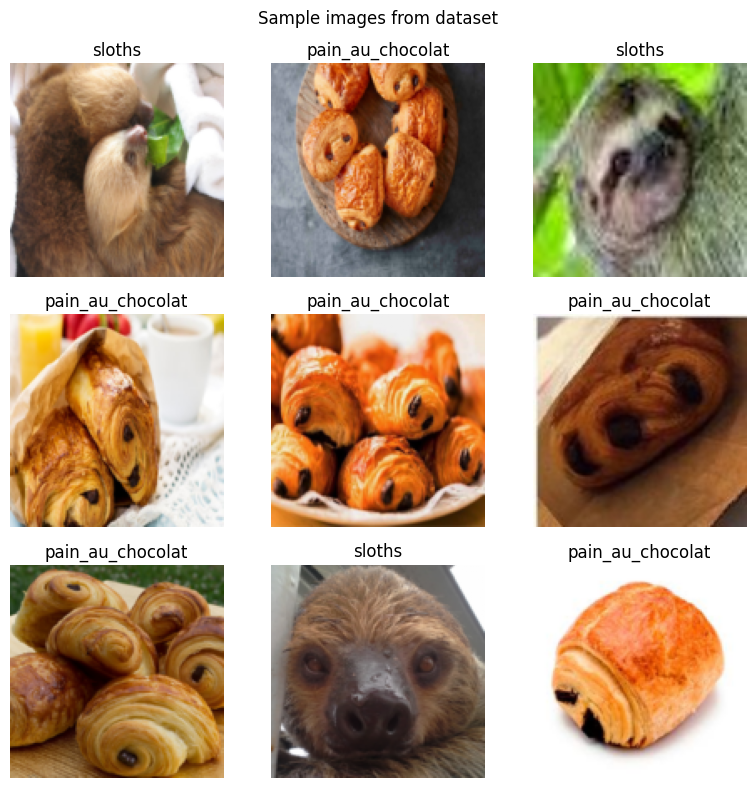

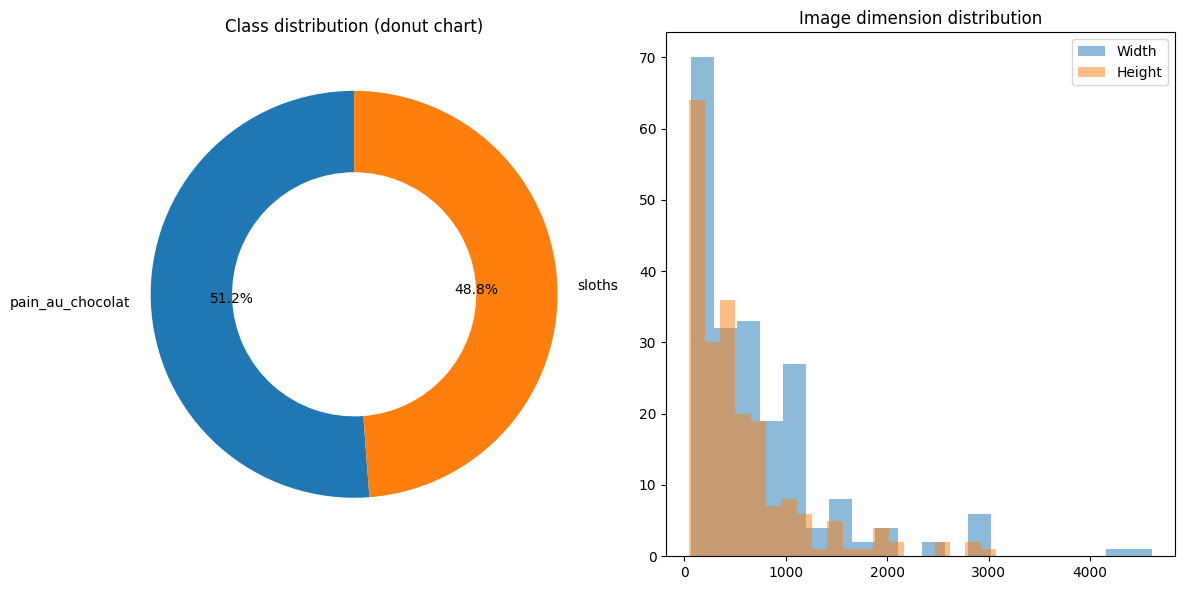

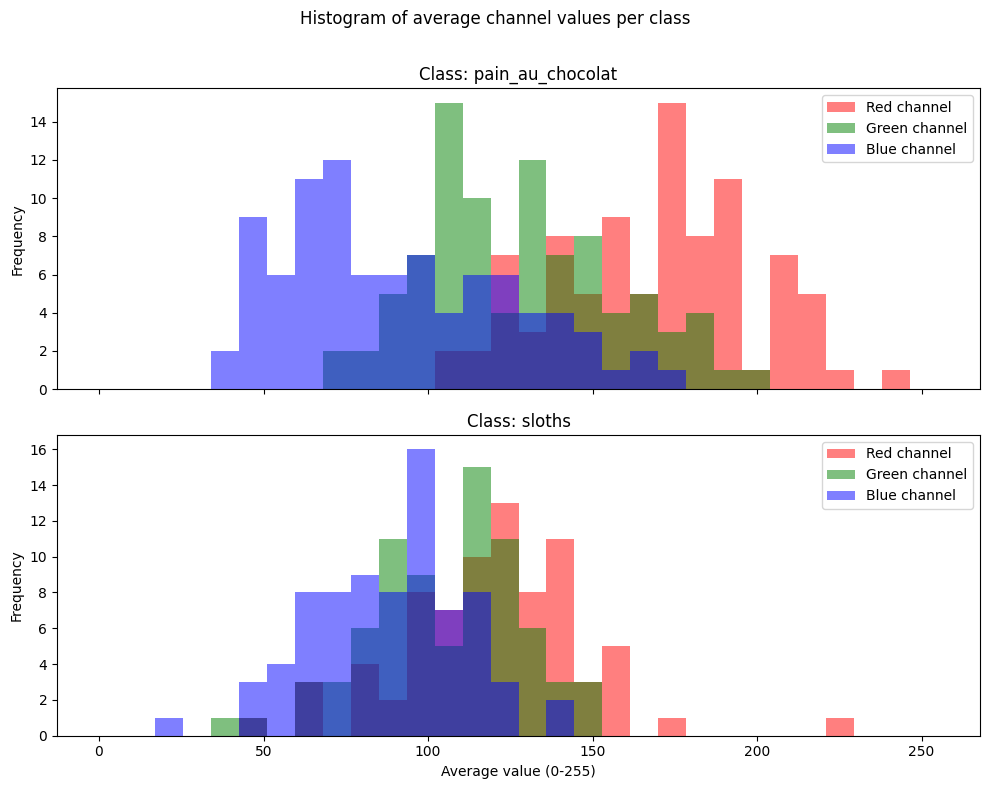

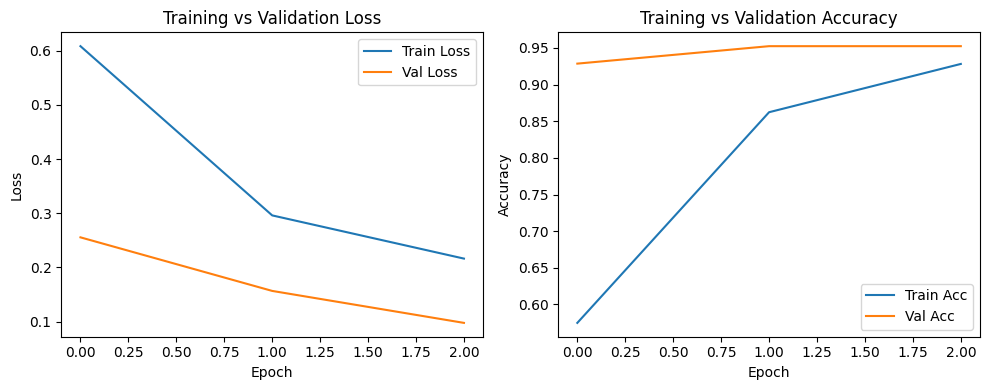

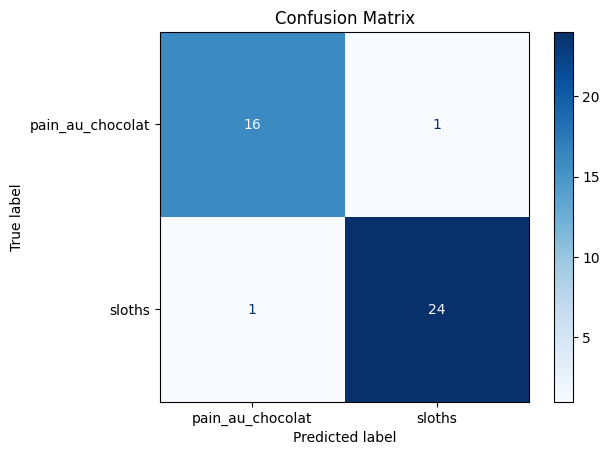

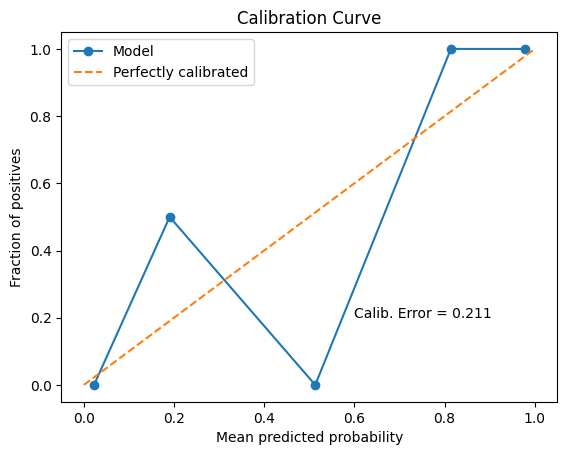

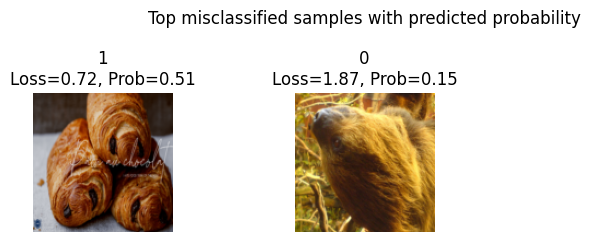

In [4]:
from visualizations import generate_visualizations

# Choose a color palette interactively (e.g., 'default', 'seaborn', 'ggplot', 'bmh', 'dark_background')
palette = input("Choose a color palette interactively (e.g., 'default', 'seaborn', 'ggplot', 'bmh', 'dark_background')")

# Generate all figures
generate_visualizations(
    train_loader=train_loader,
    class_names=class_names,
    class_dist=class_dist,
    widths=widths,
    heights=heights,
    metrics_cb=metrics_cb,
    cm=cm,
    mean_pred=mean_pred,
    frac_pos=frac_pos,
    calib_error=calib_error,
    top_samples=top_samples,
    samples=samples,
    labels_np=labels_np,
    losses=losses,
    pred_probs=pred_probs,
    color_palette=palette
)

